In [16]:
# this jupiter notebook is for using opensoundscape to visualize spectrograms from training data or original annotations 

In [2]:
"""
Created on Mon Jan 22 11:35:46 2024

@author: Michaela Alksne 

Script to run when modifying Triton logger annotation excel datasheets
converts xls to csv containing the audio file path, the annotation label, the frequency bounds, and time bounds.
saves new csv in "modified annotations subfolder"
wav is the audio file
start time = start time of call in number of seconds since start of wav 
end time = end time of call in number of seconds since start of wav

"""

from datetime import datetime
import os
import glob
import opensoundscape
import sys
from opensoundscape import Audio, Spectrogram
#sys.path.append(r"C:\Users\DAM1\CV4E")
from AudioStreamDescriptor import XWAVhdr
from AudioStreamDescriptor import WAVhdr
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


c:\Users\joon4\AppData\Local\Programs\Python\Python311\Lib\site-packages\opensoundscape\ml\cnn.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
# load datasets
CC_2004_07 = pd.read_csv('modified_annotations\MasterSheet_modification.csv')

CC_2004_07["audio_file"] = [i.replace("/Users/luisbarajas/Desktop/Projects/Course_Projects/pstat_197/master_wav_sonobuoy/", "C:/Users/joon4/OneDrive/Documents/sonobuoy/master_wav_sonobuoy/") for i in CC_2004_07["audio_file"]]

print(CC_2004_07["audio_file"][0])


C:/Users/joon4/OneDrive/Documents/sonobuoy/master_wav_sonobuoy/CC0407-SB2-040713-235000.wav


c:\Users\joon4\AppData\Local\Programs\Python\Python311\Lib\site-packages\opensoundscape\audio.py:328: UserWarning: audio object has zero samples
  warnings.warn(error_msg)


No audio samples found for file: C:/Users/joon4/OneDrive/Documents/sonobuoy/master_wav_sonobuoy/CC0407-SB10-040717-223000.wav


C:\Users\joon4\AppData\Local\Temp\ipykernel_13320\3112396539.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 8))


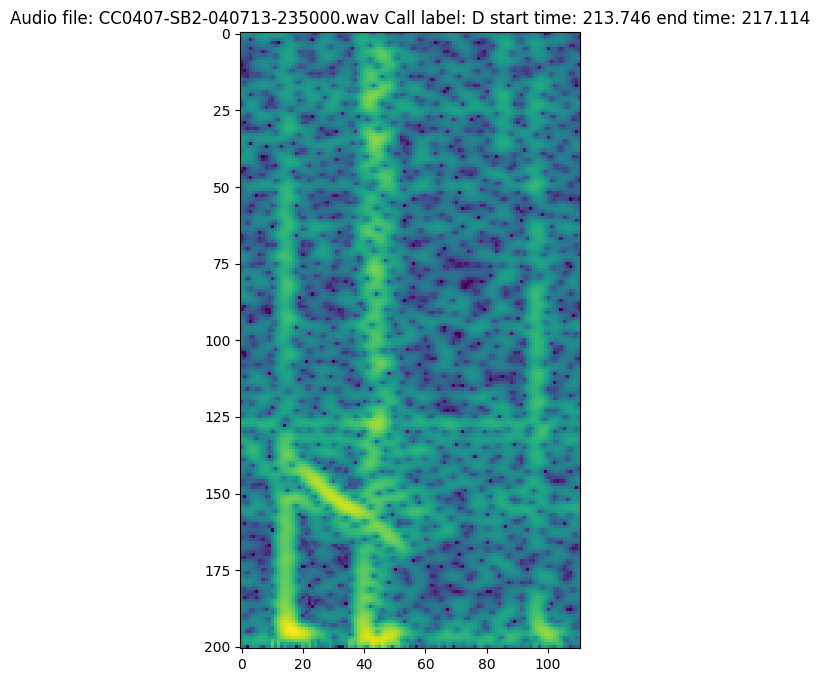

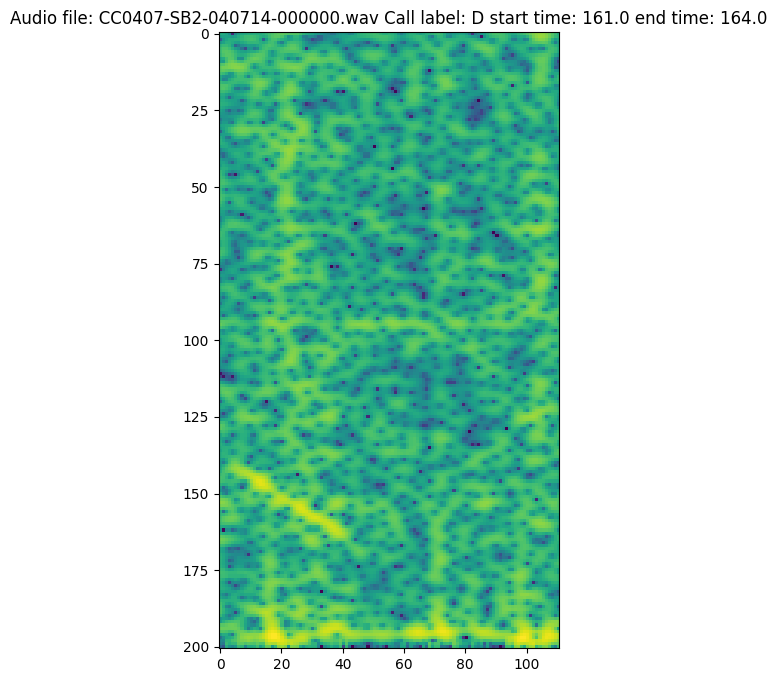

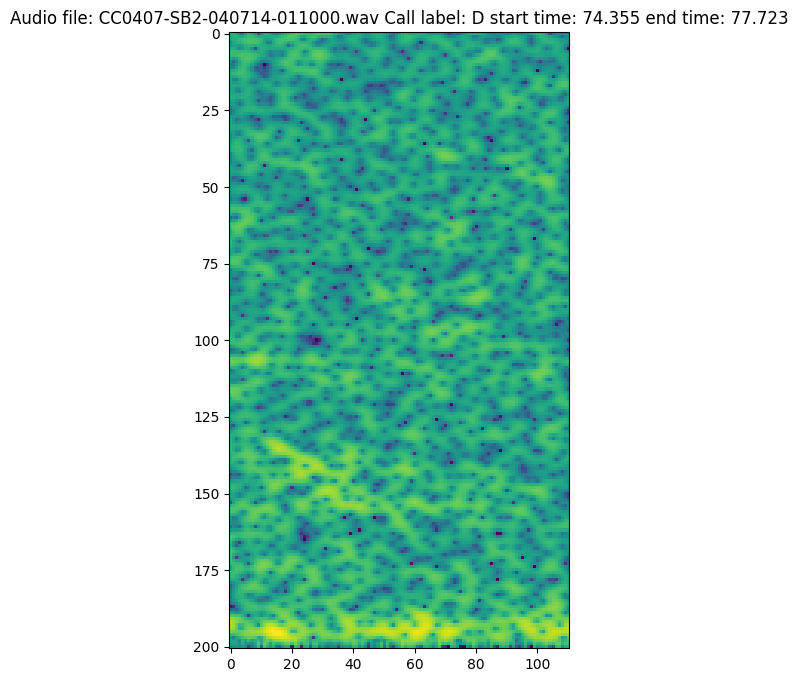

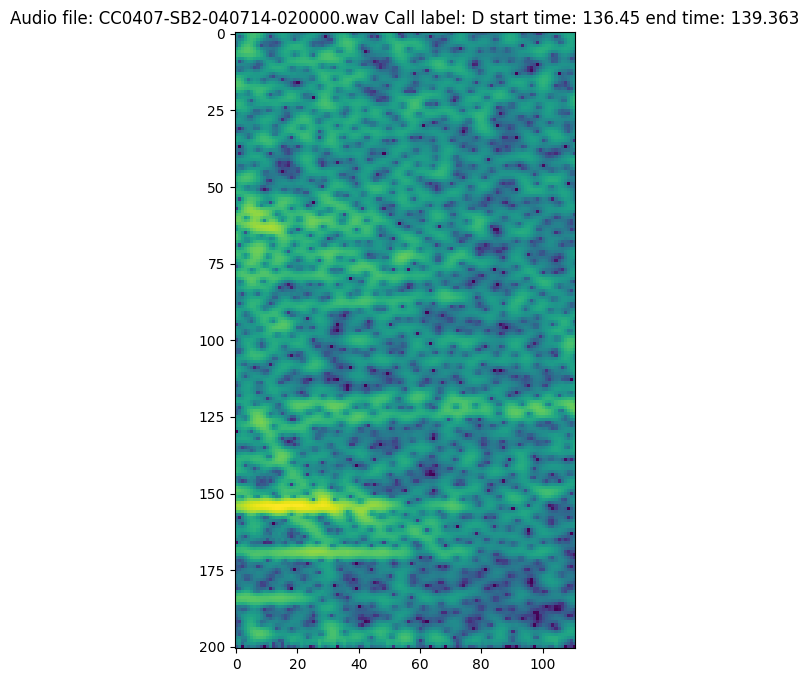

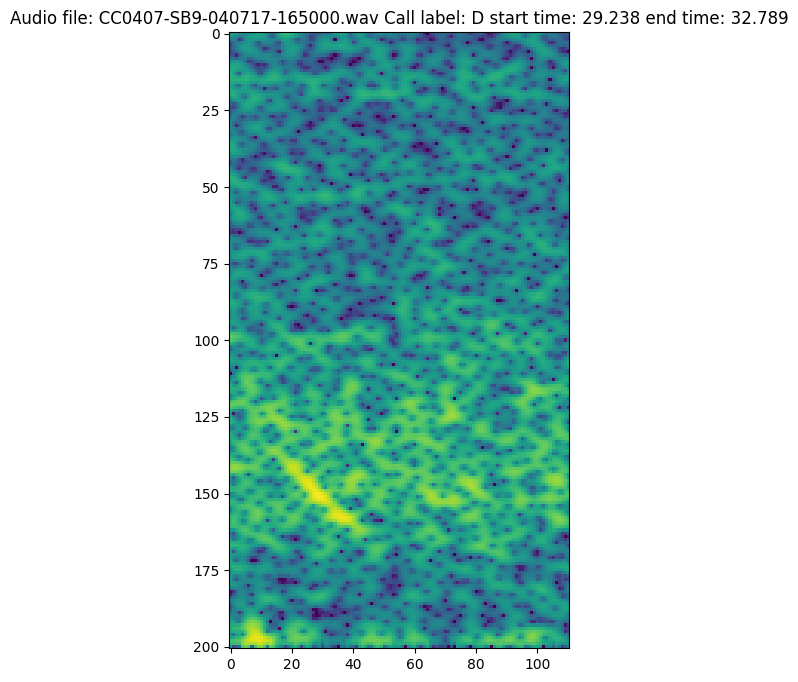

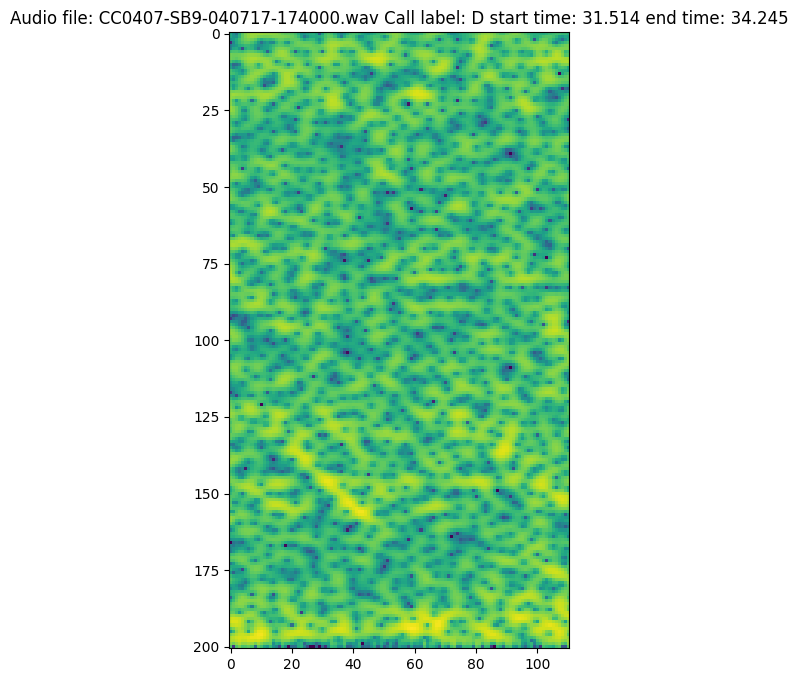

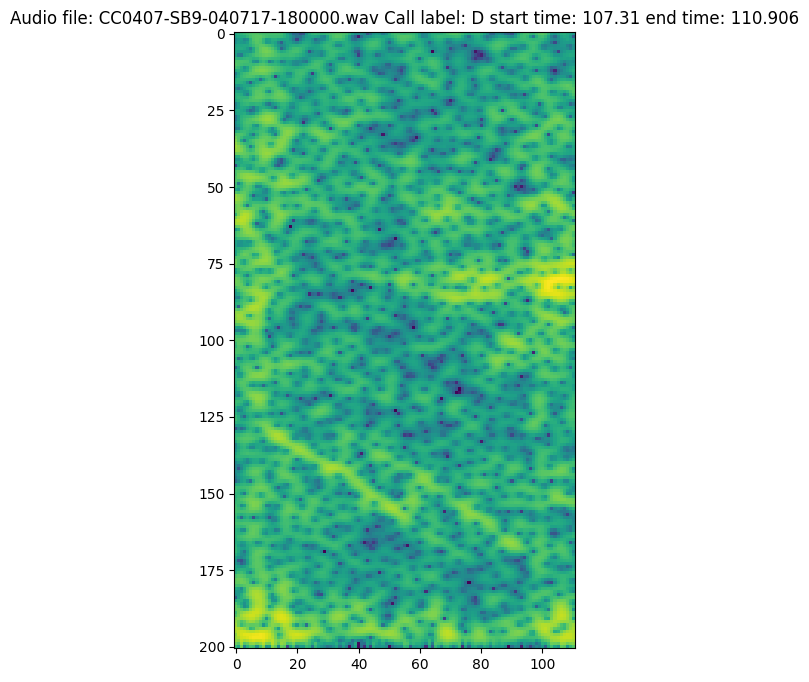

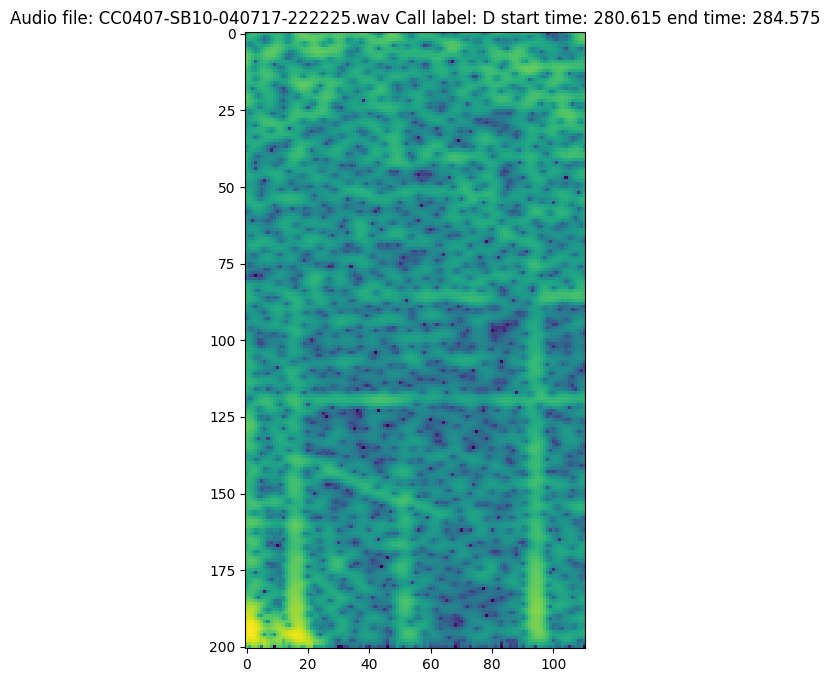

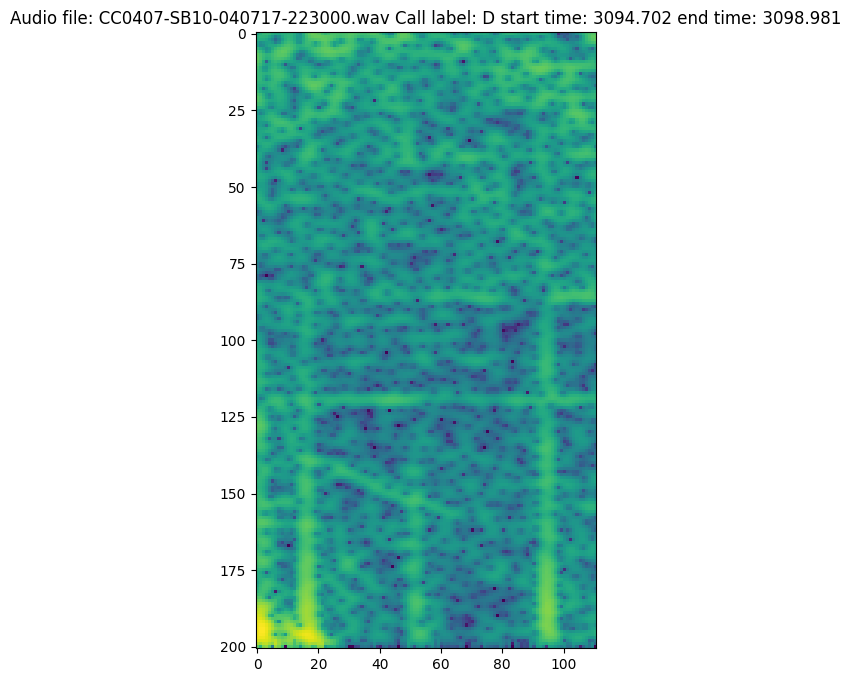

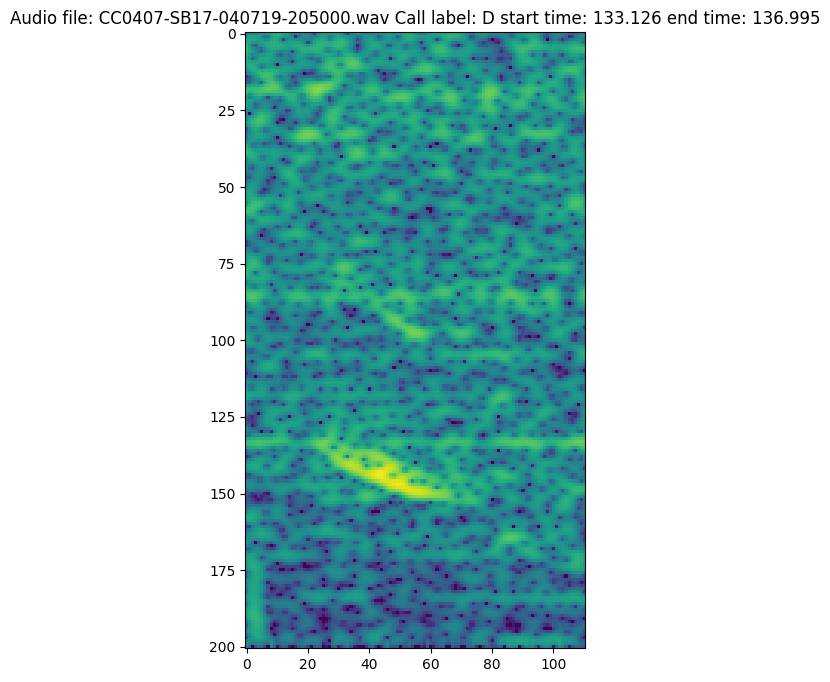

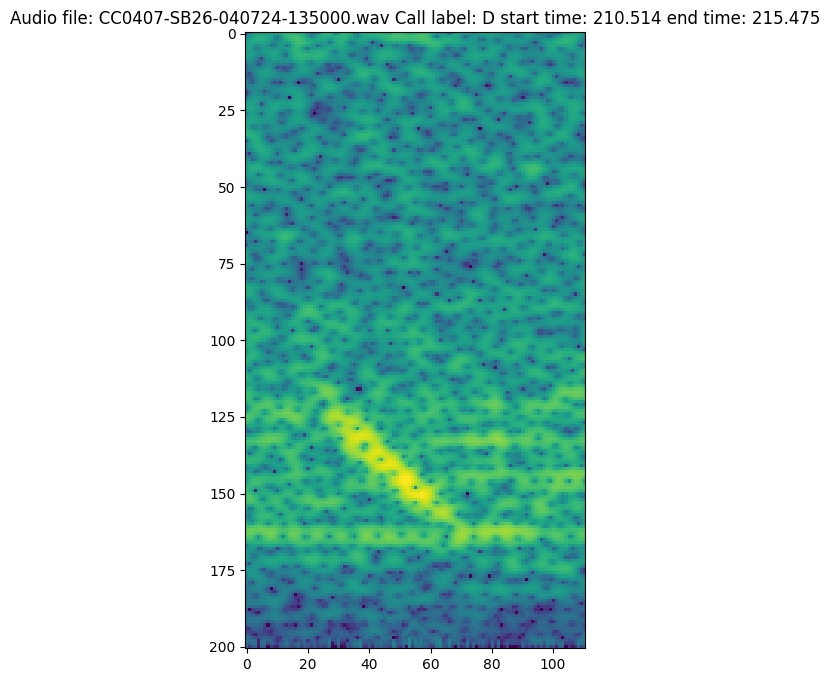

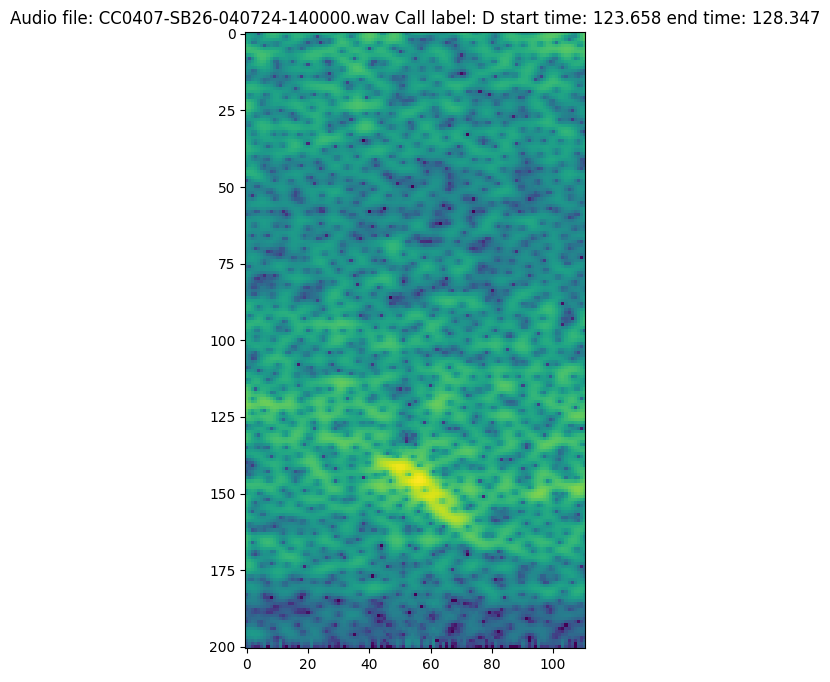

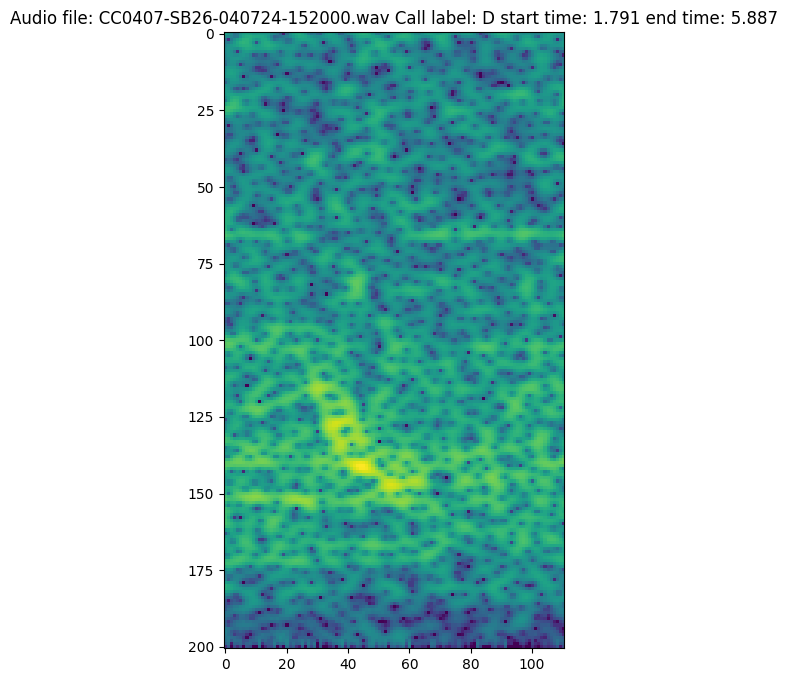

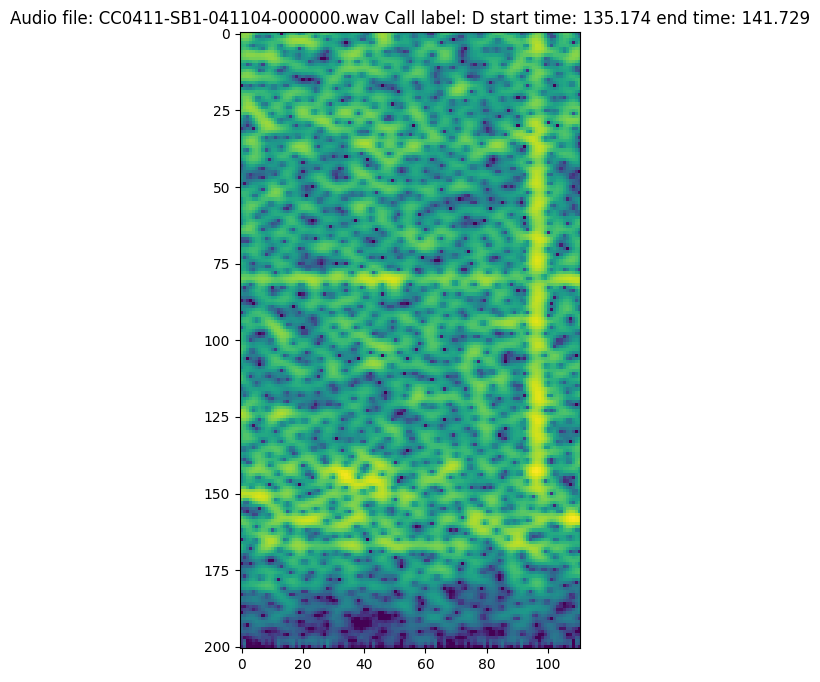

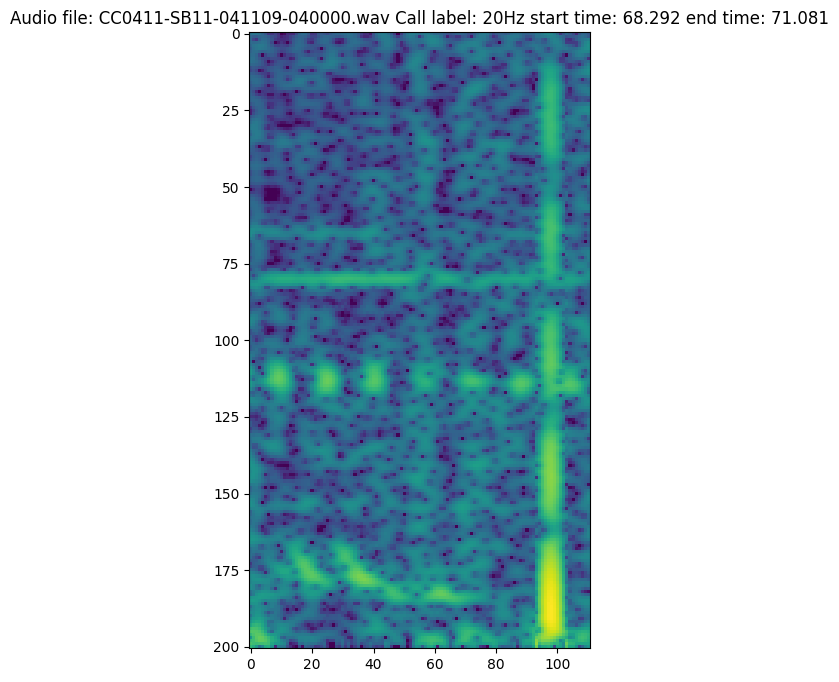

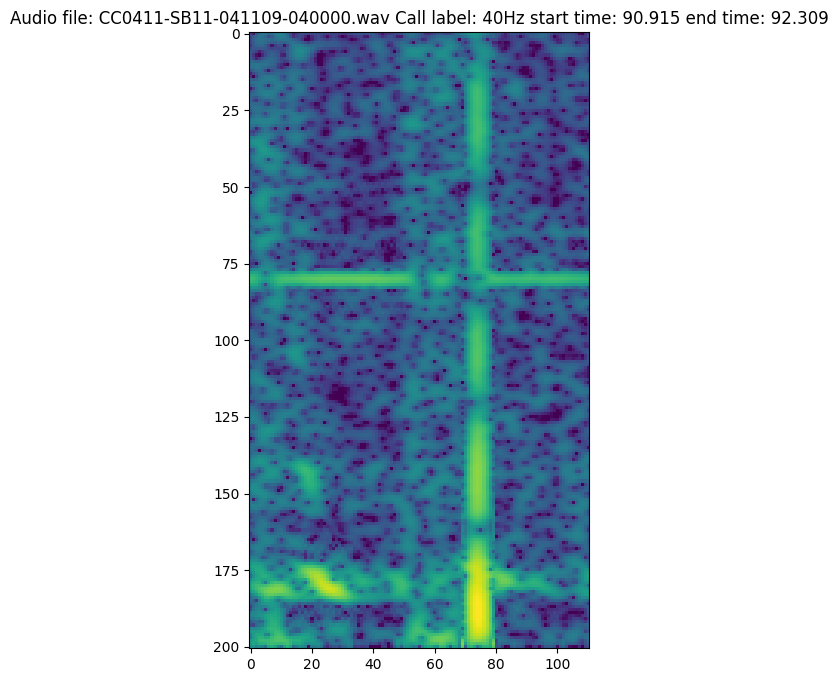

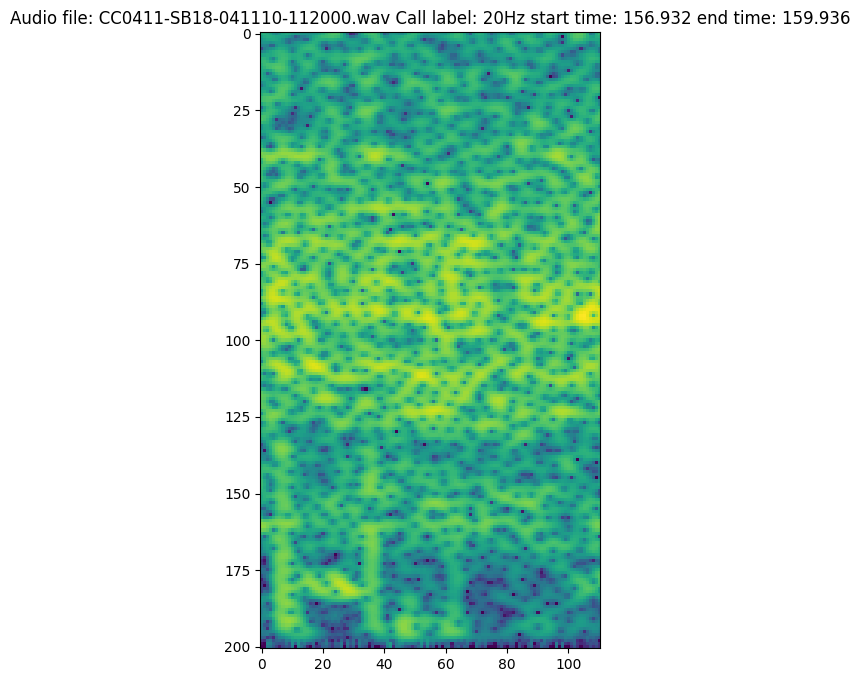

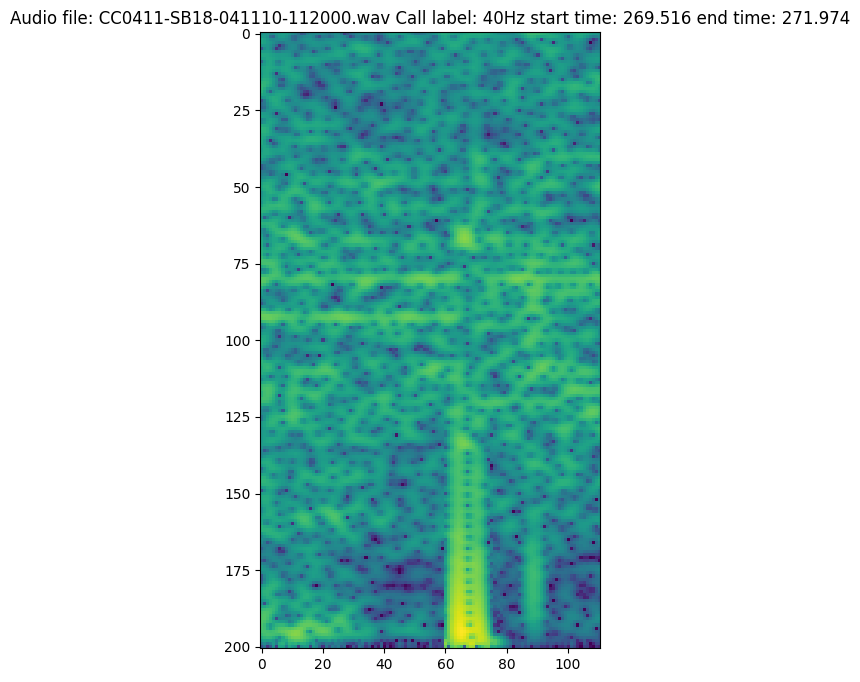

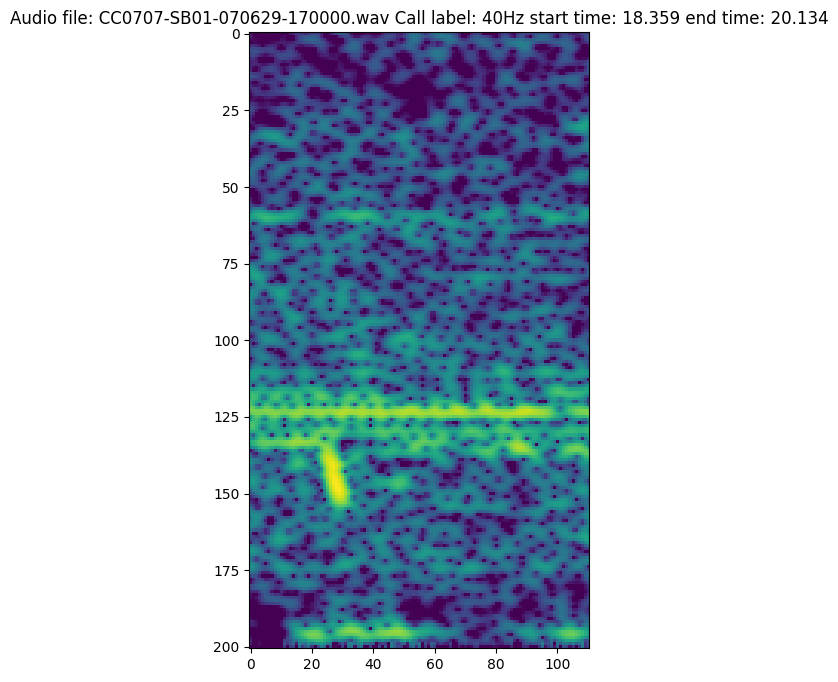

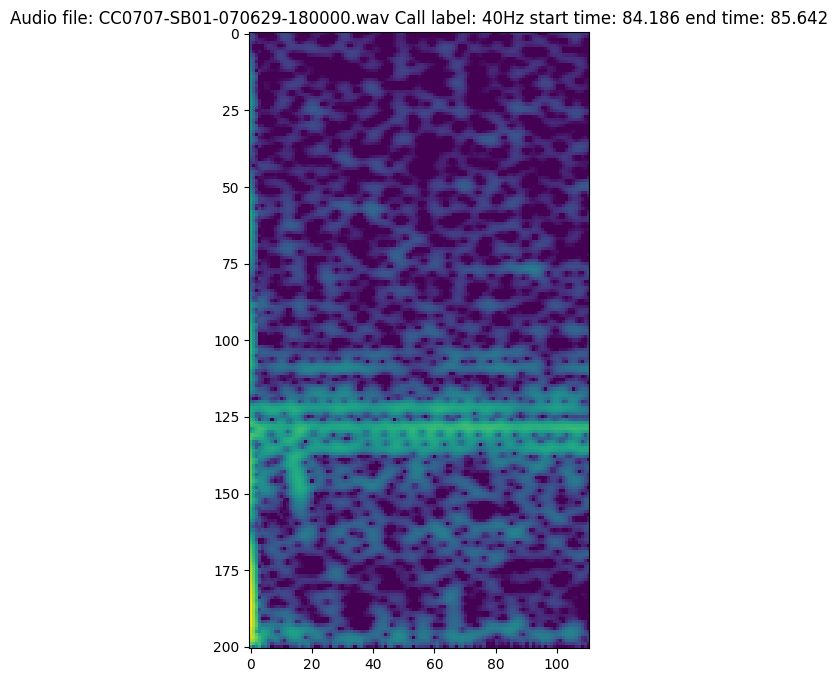

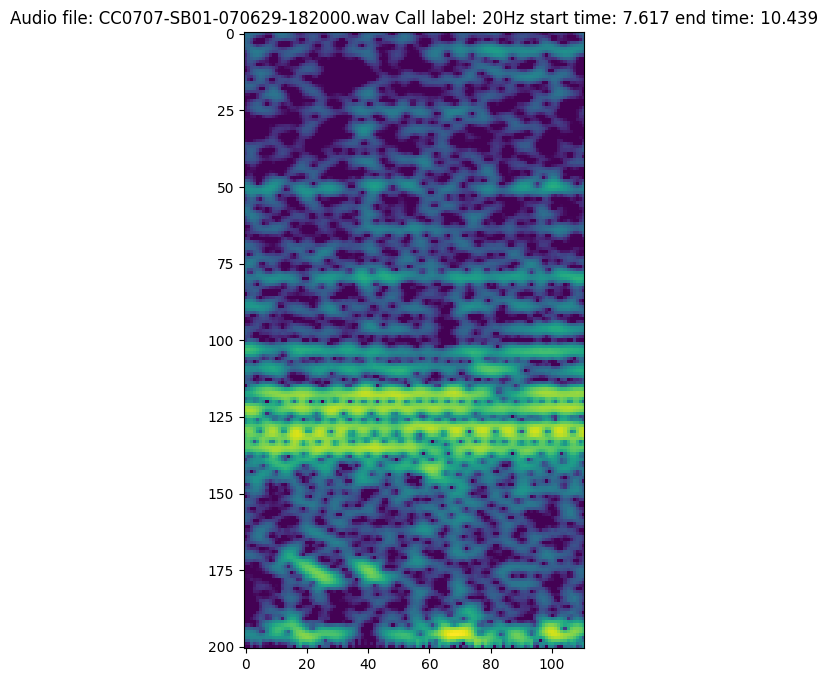

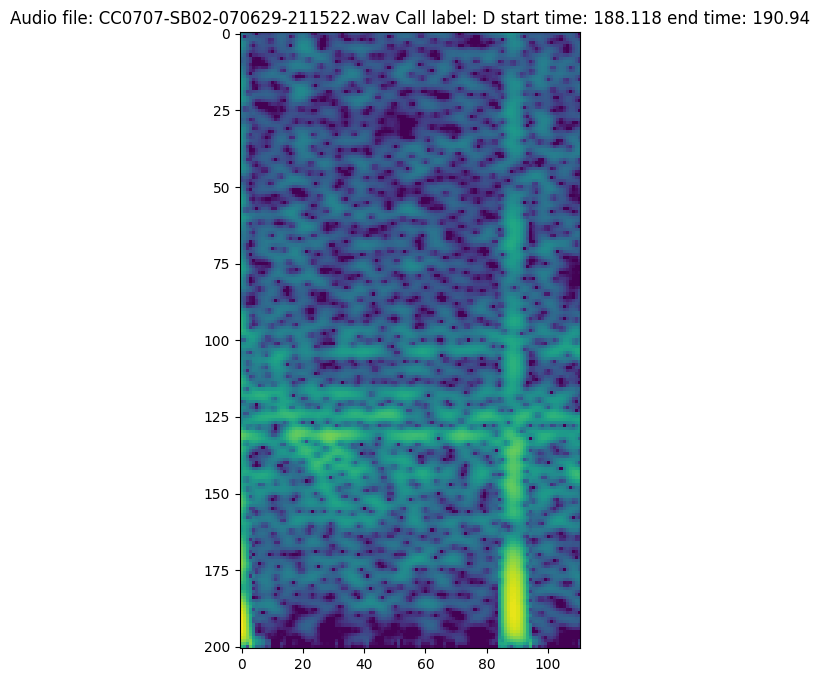

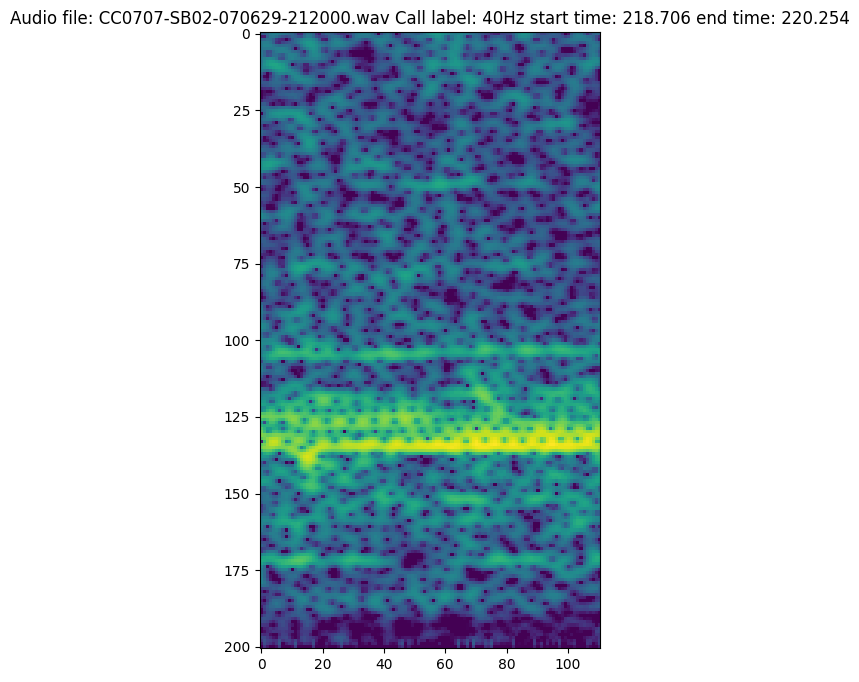

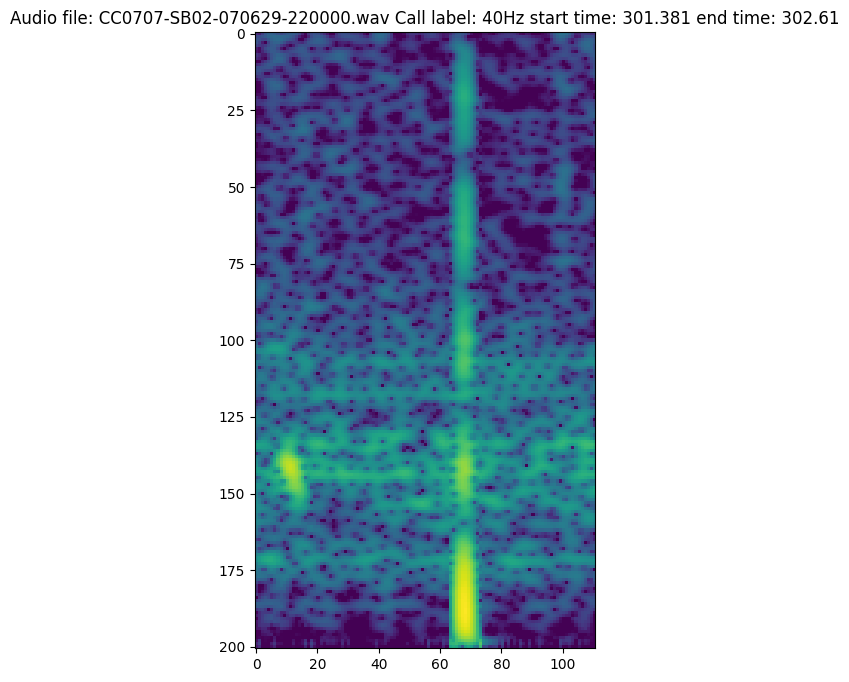

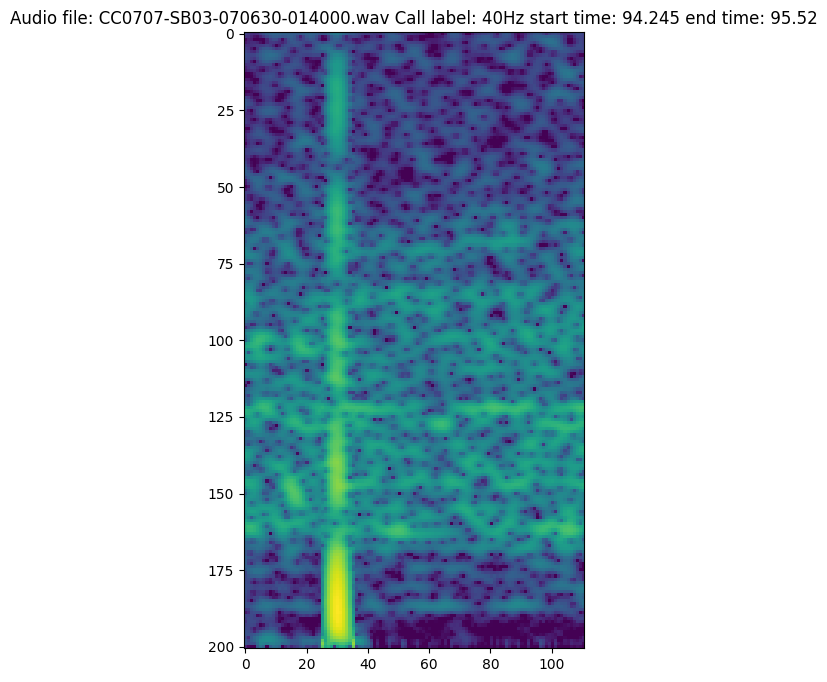

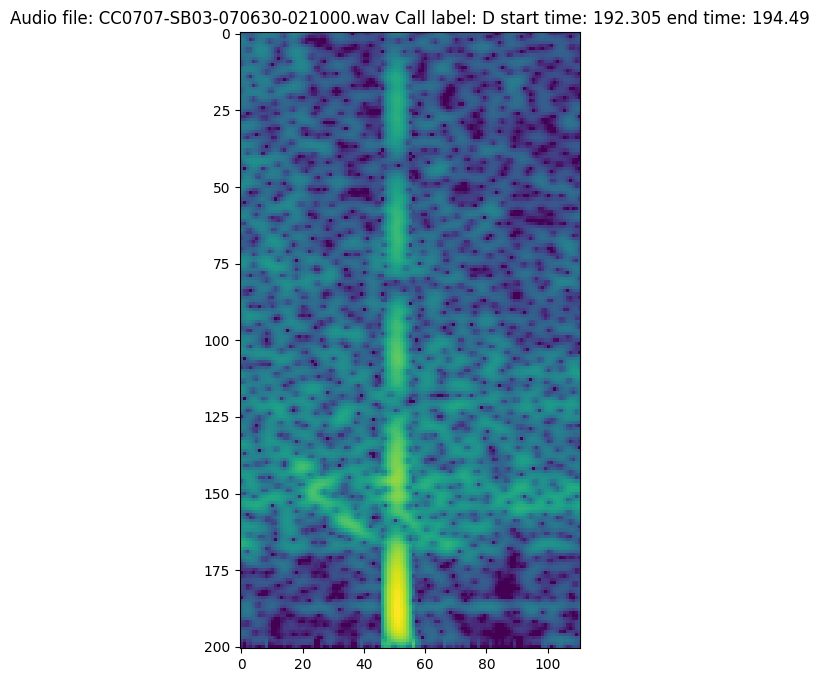

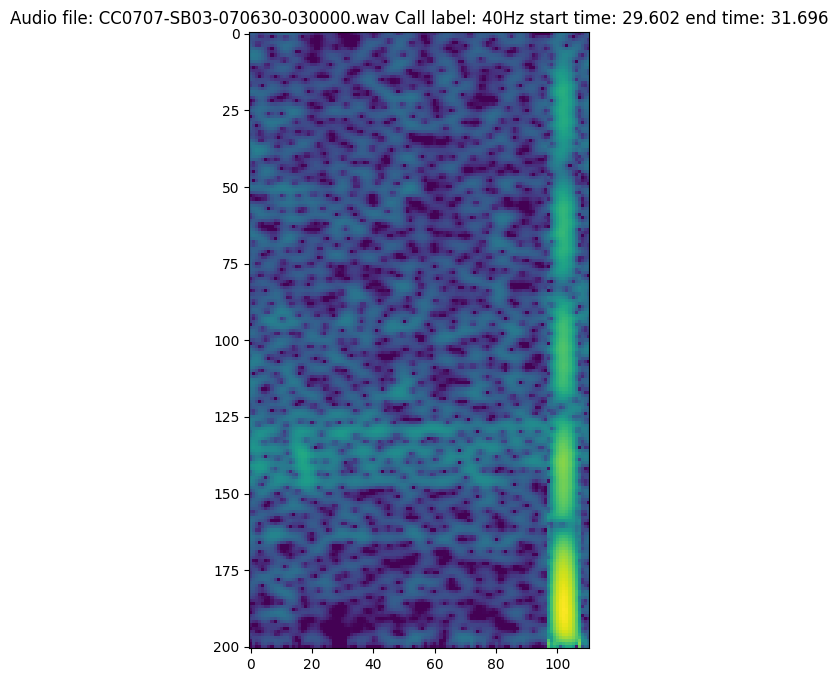

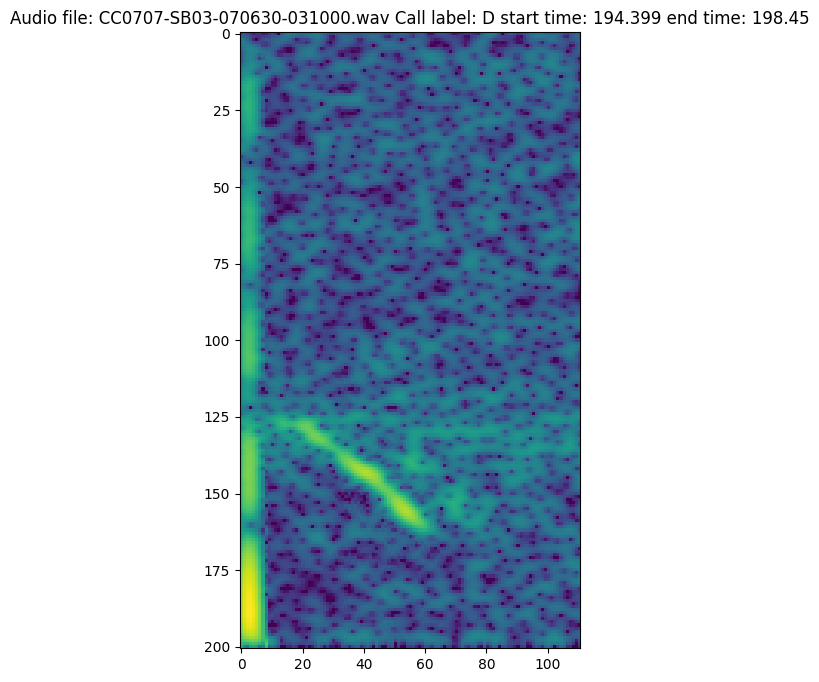

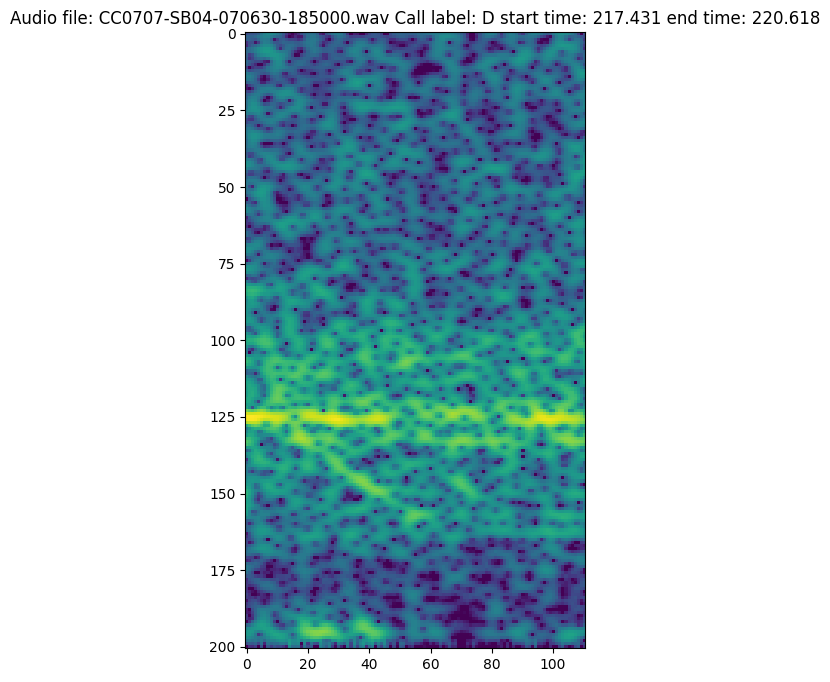

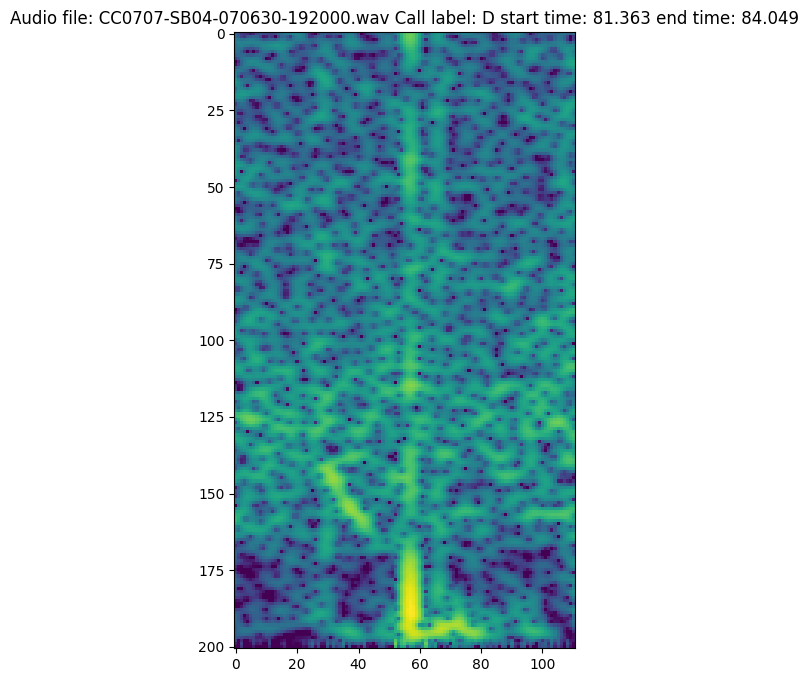

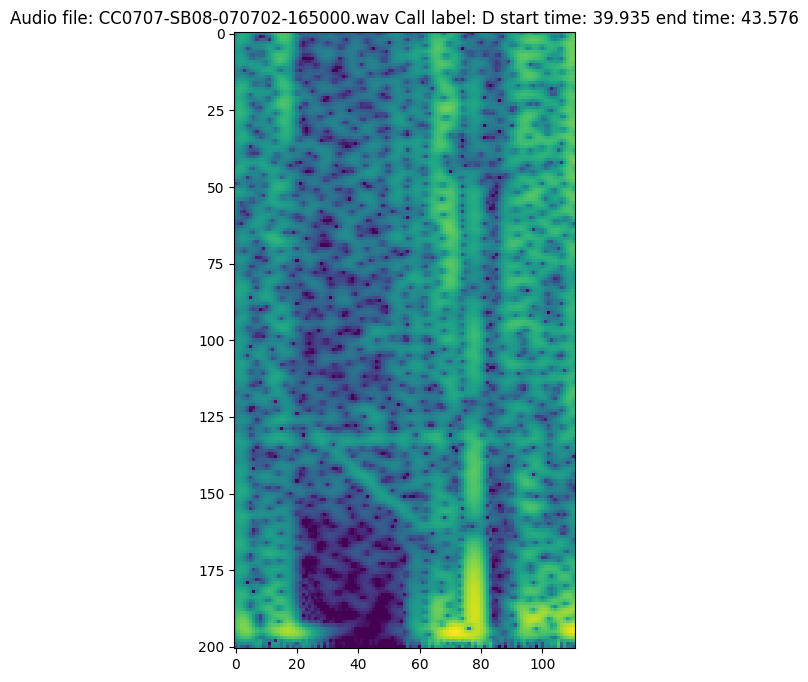

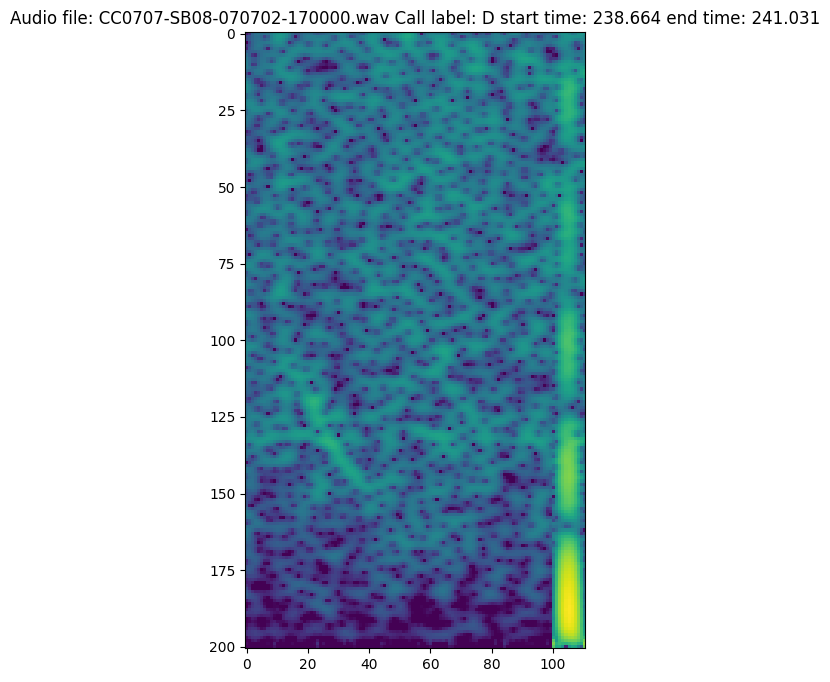

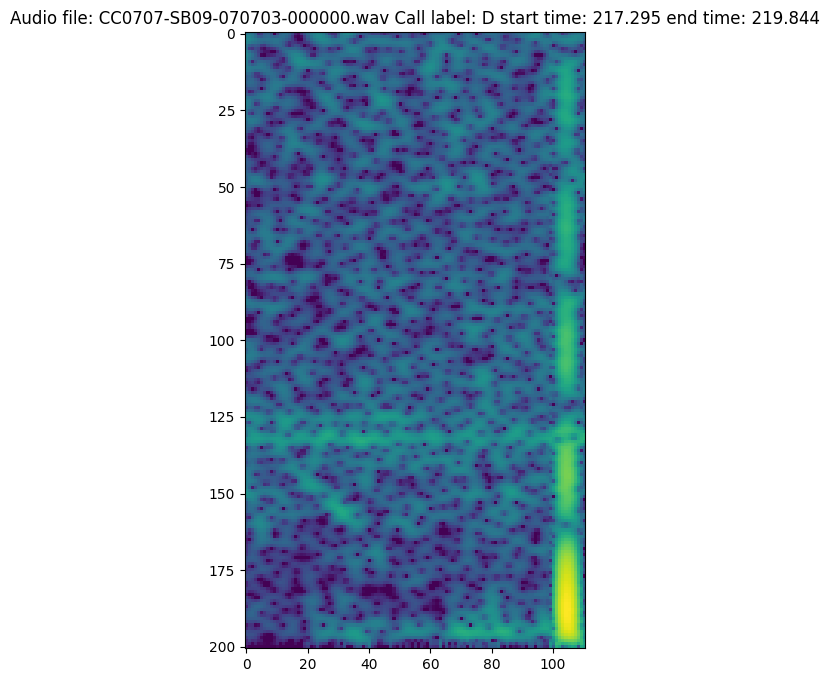

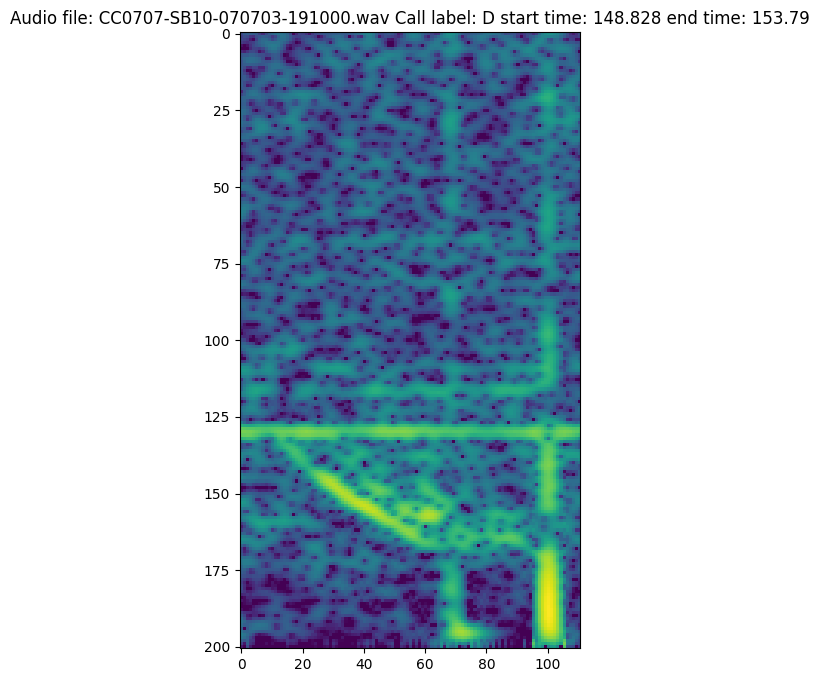

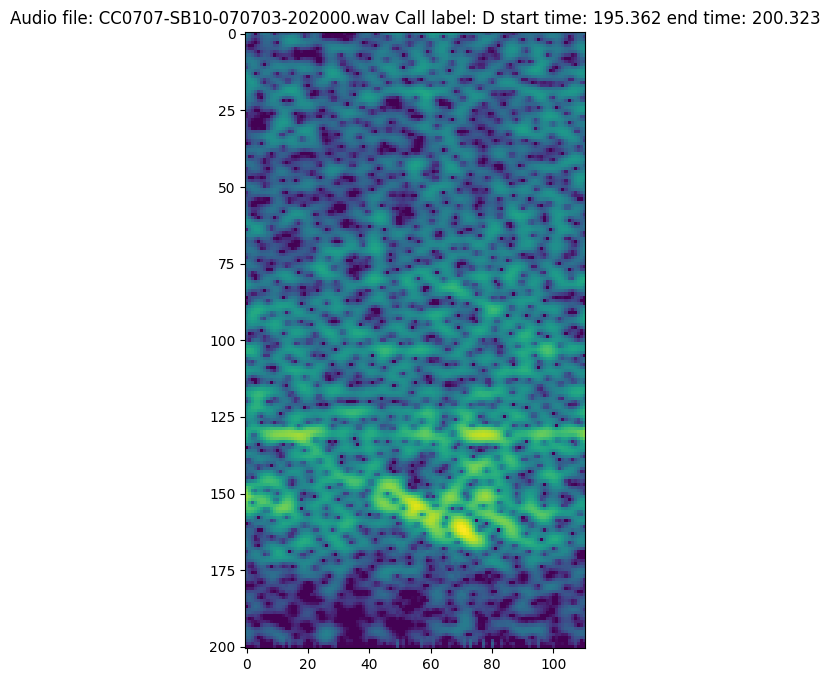

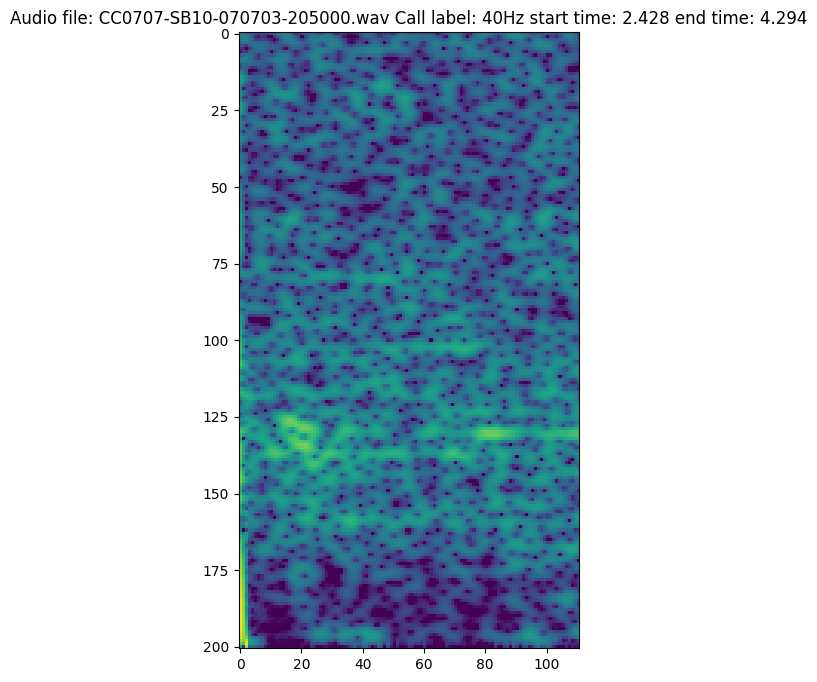

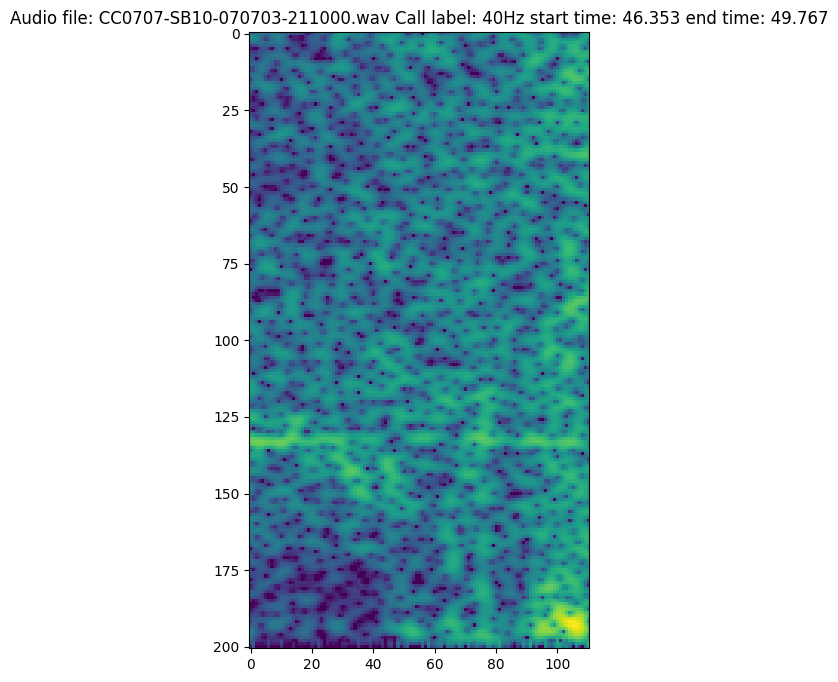

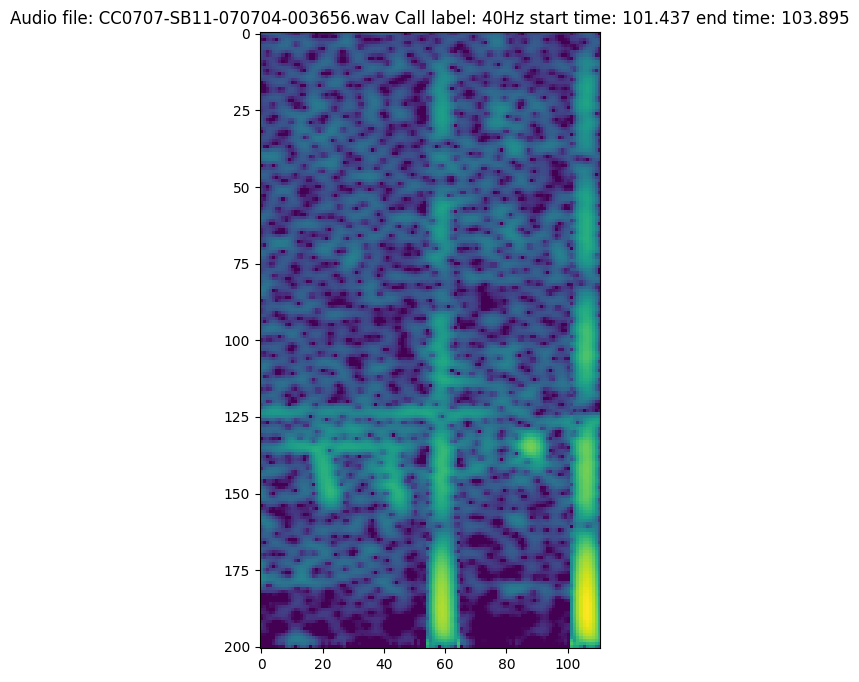

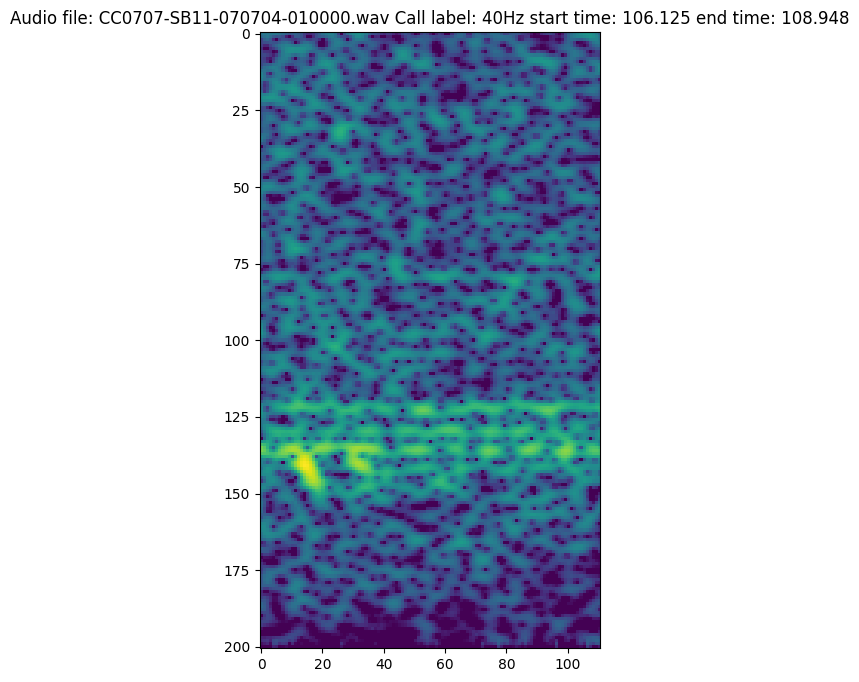

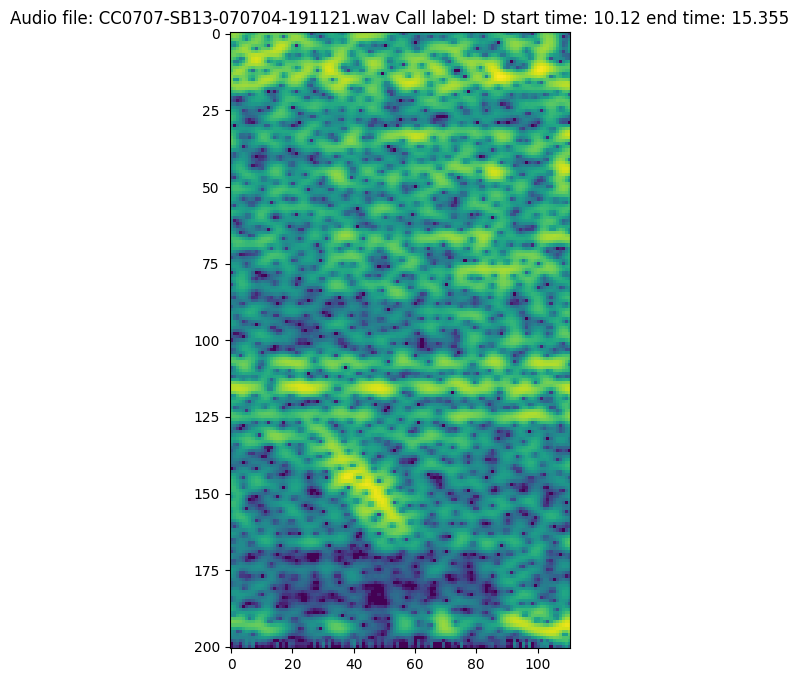

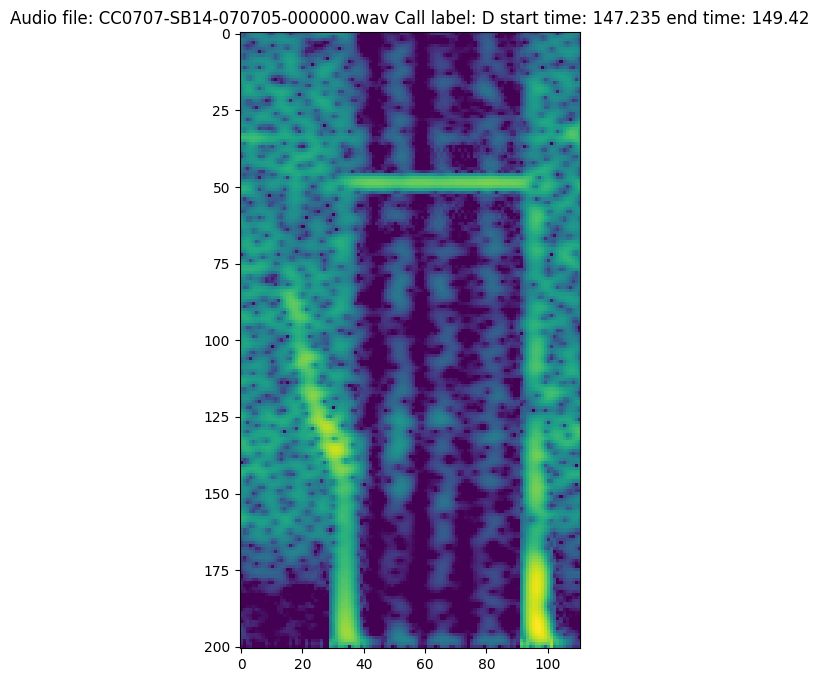

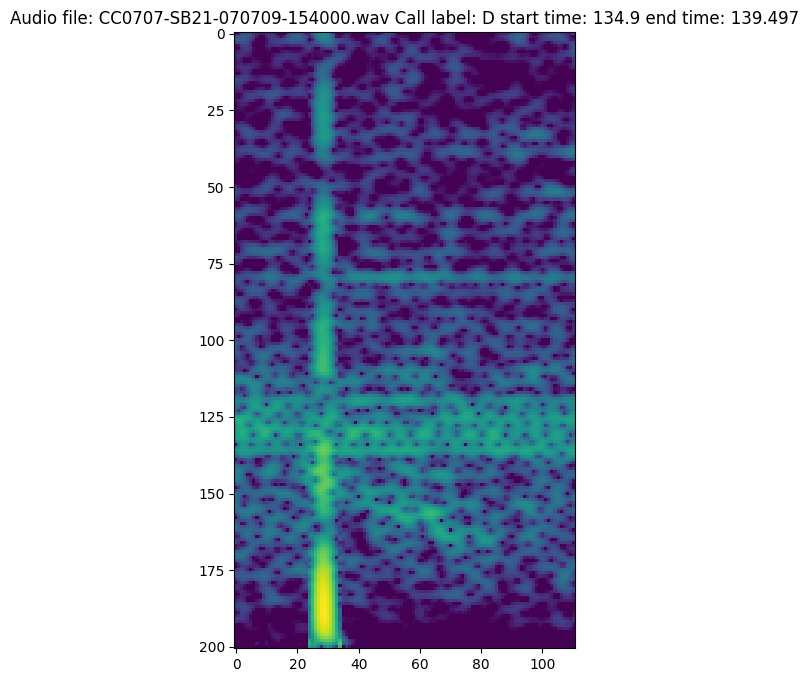

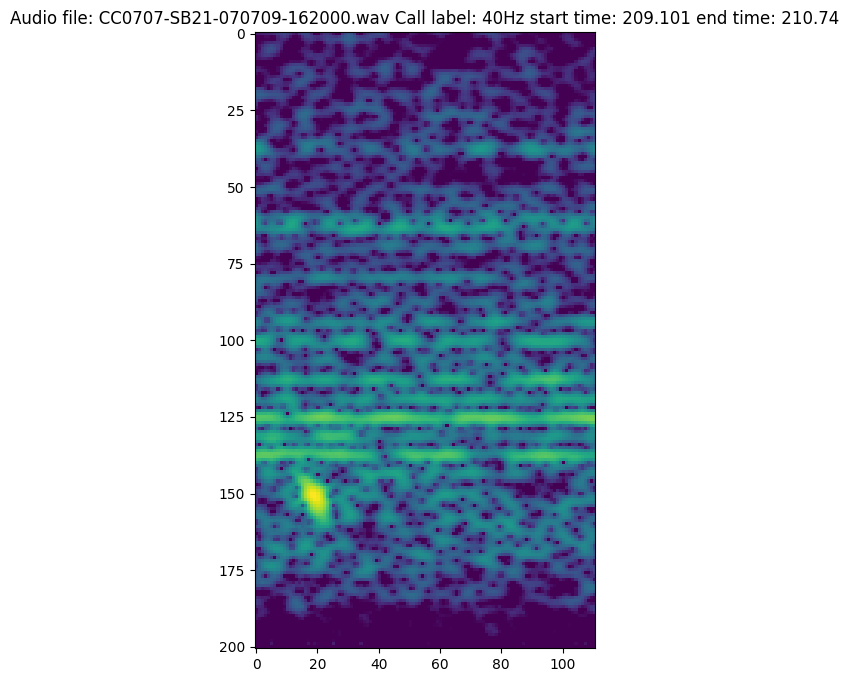

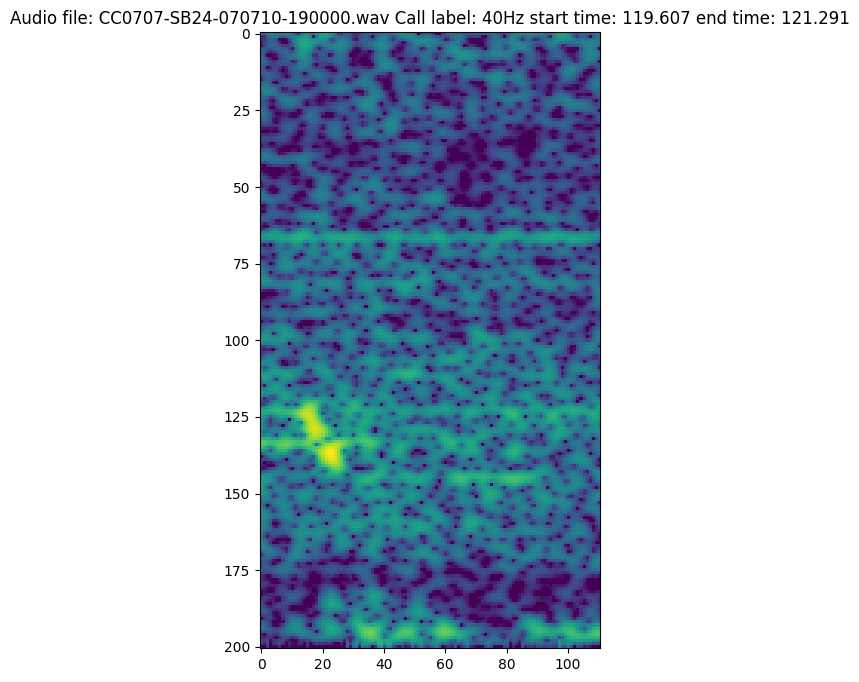

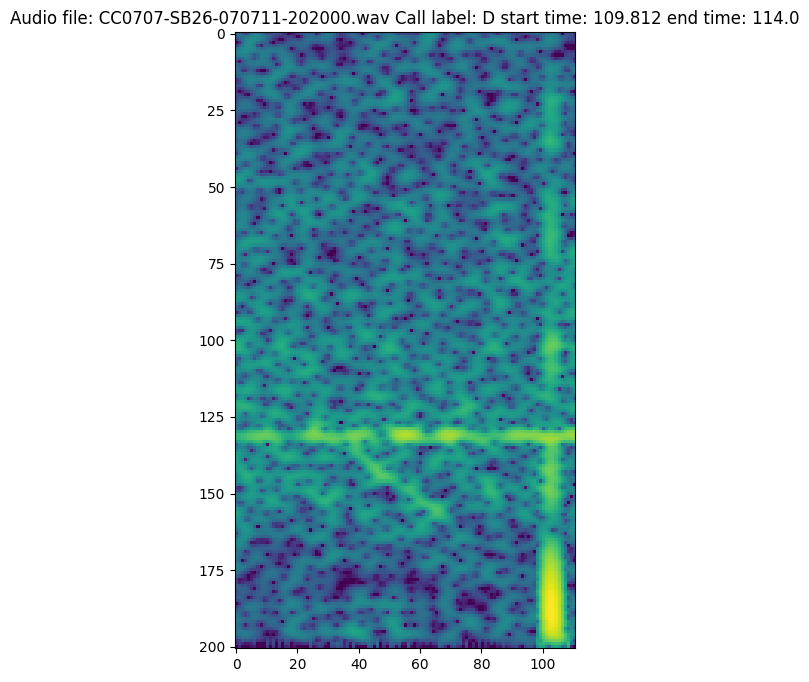

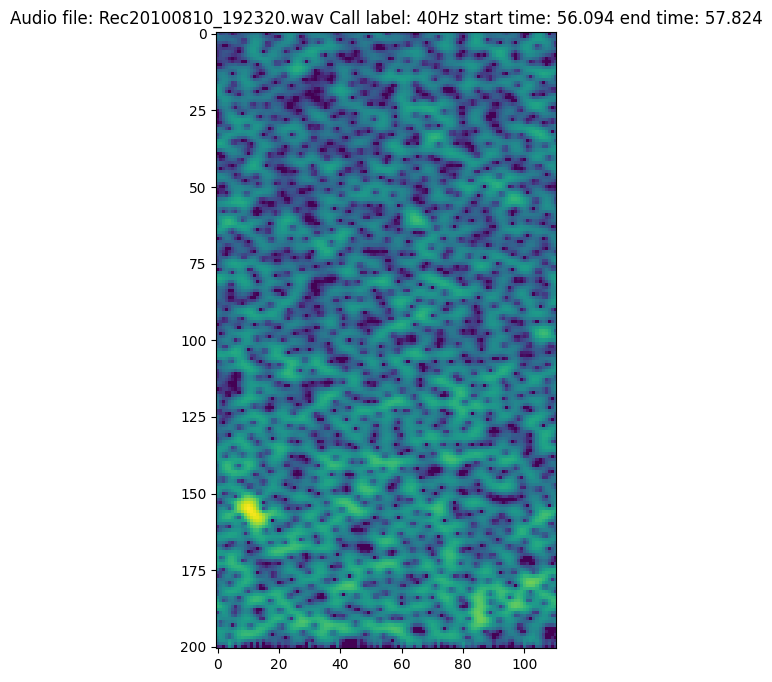

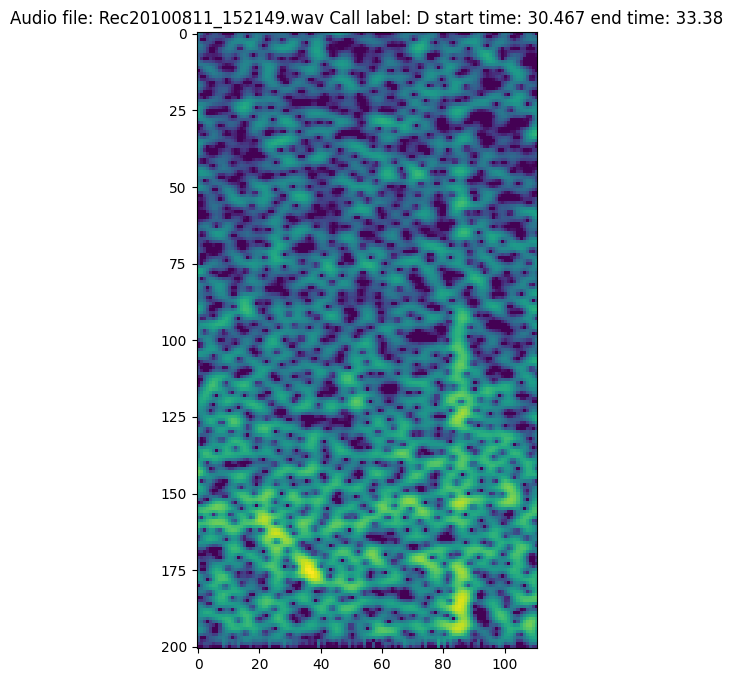

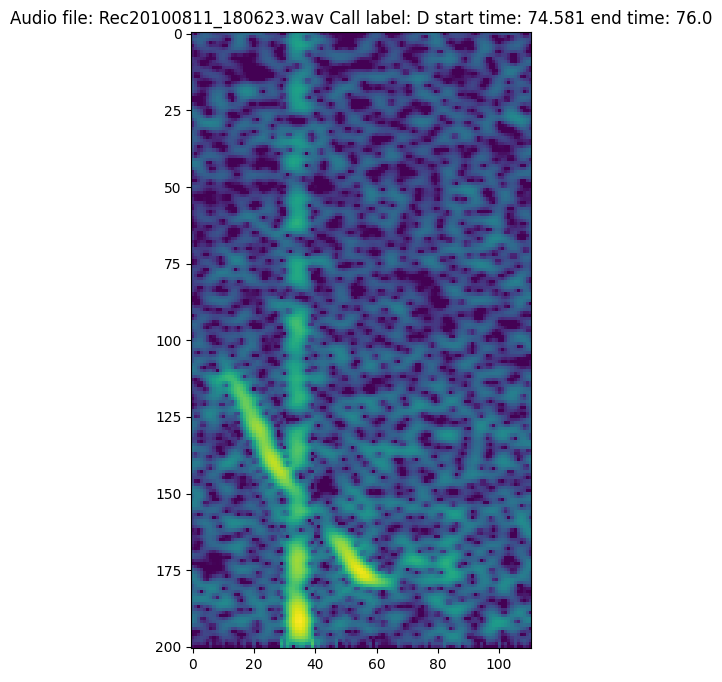

In [4]:
# plot spectrograms from each deployment
# CalCOFI-2004-07
for index, row in CC_2004_07.iterrows():

    audio_file_name = os.path.split(row['audio_file'])[1]
    audio = opensoundscape.Audio.from_file(row['audio_file'], sample_rate=48000, offset=row['start_time'], duration=6)

    if audio.samples.shape[0] > 0:  # Assuming audio.samples returns a numpy array of audio samples
        spec = opensoundscape.Spectrogram.from_audio(audio, window_type='hamming', window_samples=24000, 
                                                     overlap_samples=21600, fft_size=48000, 
                                                     scaling='density')
        spec_image = spec.bandpass(0, 200).to_image()
    #spec = opensoundscape.Spectrogram.from_audio(audio, window_type='hamming', window_samples=24000, 
                                             #overlap_samples=21600, fft_size=48000, 
                                             #scaling='density')

    #spec = opensoundscape.Spectrogram.from_audio(audio, window_type='hamming', window_samples=24000, 
                                                                #overlap_samples=21600, fft_size=48000, 
                                                                #decibel_limits=(-100, 100), scaling='density')
    else:
        print(f"No audio samples found for file: {row['audio_file']}")

    #spec_image = spec.bandpass(0, 200).to_image()
    plt.figure(figsize=(12, 8))
    plt.imshow(spec_image)
    plt.title(f'Audio file: {audio_file_name} Call label: {row["annotation"]} start time: {row["start_time"]} end time: {row["end_time"]}')
    plt.axis('on')

In [5]:
spec_vecs = []

for index, row in CC_2004_07.iterrows():

    audio_file_name = row['audio_file'][1]
    audio = opensoundscape.Audio.from_file(row['audio_file'], sample_rate=48000, offset=row['start_time'], duration=6)

    if audio.samples.shape[0] > 0:  # Assuming audio.samples returns a numpy array of audio samples
        spec = opensoundscape.Spectrogram.from_audio(audio, window_type='hamming', window_samples=24000, 
                                                     overlap_samples=21600, fft_size=48000, 
                                                     scaling='density')
        spec_image = spec.bandpass(0, 200).to_image()
        spec_vecs.append(np.array(spec_image))



    else:
        print(f"No audio samples found for file: {row['audio_file']}")
        spec_vecs.append(0)

c:\Users\joon4\AppData\Local\Programs\Python\Python311\Lib\site-packages\opensoundscape\audio.py:328: UserWarning: audio object has zero samples
  warnings.warn(error_msg)


No audio samples found for file: C:/Users/joon4/OneDrive/Documents/sonobuoy/master_wav_sonobuoy/CC0407-SB10-040717-223000.wav


In [6]:
CC_2004_07_mod1 = CC_2004_07
CC_2004_07_mod1['spectogram_matrix'] = spec_vecs
CC_2004_07_mod2 = CC_2004_07_mod1
CC_2004_07_mod2 = CC_2004_07_mod2[CC_2004_07['audio_file'] != 'C:/Users/joon4/OneDrive/Documents/sonobuoy/master_wav_sonobuoy/CC0407-SB10-040717-223000.wav']


def reshape_spectrograms(df, column_name='spectrograms'):

    # Reshape each 2D array into a 1D vector and store in a list
    vectors = df[column_name].apply(lambda x: x.flatten())

    # Convert the list of vectors into a 2D numpy array (matrix)
    matrix = np.stack(vectors.to_numpy())

    return matrix

spectogram_matrix = reshape_spectrograms(CC_2004_07_mod2, 'spectogram_matrix')

print("Shape of the data matrix:", spectogram_matrix.shape)


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_std=False)
data_matrix_mod2 = scaler.fit_transform(spectogram_matrix)
original_data = data_matrix_mod2

Shape of the data matrix: (47, 22311)


In [7]:
def draw_img(img_vector, h=201, w=111):
    """
    1. takes img_vector,
    2. reshapes into right dimensions,
    3. draws the resulting image
    """
    
    
    plt.imshow( (img_vector).reshape(h,w), cmap=plt.cm.gray)
    
    plt.xticks(())
    plt.yticks(())

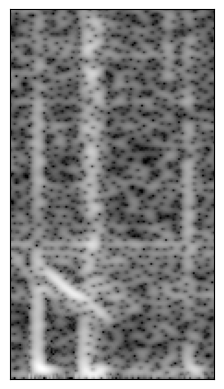

In [8]:

U, S, T = np.linalg.svd(original_data, full_matrices=False)


US = U*S

svd_data = US @ T

svd_data_scaled = scaler.inverse_transform(svd_data)

draw_img(svd_data_scaled[0])


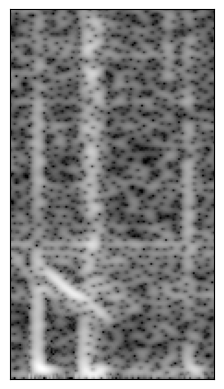

In [9]:
svd_data_2000 = US[:, 0:500] @ T[0:500, :]
svd_2000 = scaler.inverse_transform(svd_data_2000)
draw_img(svd_2000[0])

In [6]:
from sklearn.decomposition import NMF

original_data_copy = original_data

for i in original_data_copy:
    min_val = np.min(i)
    if min_val < 0:
        i -= min_val




model = NMF(n_components=30, init='nndsvd', random_state=0, max_iter=1000)
W = model.fit_transform(original_data_copy)
H = model.components_

nmf_data = W @ H

c:\Users\joon4\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


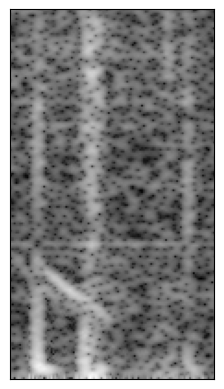

In [15]:
draw_img(nmf_data[0])

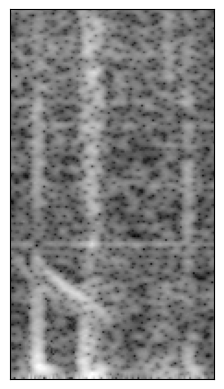

In [12]:
from sklearn.decomposition import FastICA
from pylab import *
from skimage import data, io, color
original_data_copy = original_data
X = svd_data_2000

ica = FastICA(n_components=25)
S_ = ica.fit_transform(original_data_copy)
X_restored = ica.inverse_transform(S_)

draw_img(X_restored[0])

